# Task 3 - Convolutional Neural Network

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import source code
import sys
sys.path.insert(0, '../src')

from Task_3.neural_network import NeuralNetwork
from Task_3.conv_neural_network import VanillaCNN, ImprovedCNN

## Data set

Import data set:

*Source*: https://www.kaggle.com/datasets/zalando-research/fashionmnist


Fashion MNIST classification:
*   0   T-shirt/top
* 1 	Trouser
* 2 	Pullover
* 3 	Dress
* 4 	Coat
* 5 	Sandal
* 6 	Shirt
* 7 	Sneaker
* 8 	Bag
* 9 	Ankle boot


To import the dataset, you need to download the two files 'fashion-mnist_train.csv' and 'fashion-mnist_test.csv' from the *Source* link and save them in the *data/*  folder of the repository

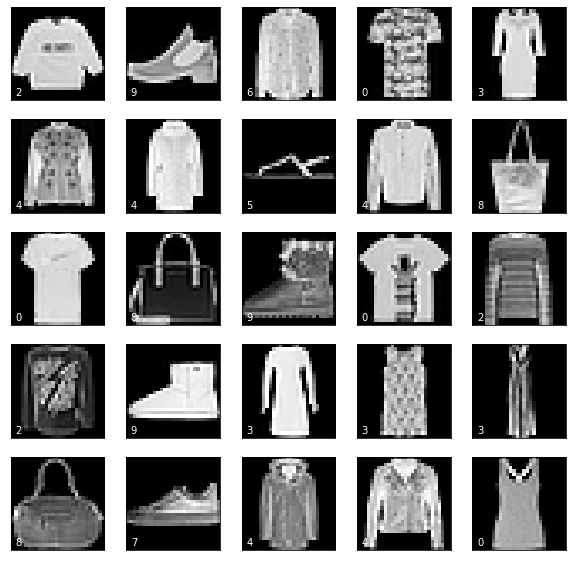

In [6]:
# Import the data sets
path = "../data/fashon_MNIST/"
train = pd.read_csv(path + "fashion-mnist_train.csv")
test = pd.read_csv(path + "fashion-mnist_test.csv")

y_train = train["label"].values
y_test = test["label"].values

X_train = (train.iloc[:,1:].values).astype('float32')
X_test = (test.iloc[:,1:].values).astype('float32')

# Display some images
fig, axes = plt.subplots(5,5, figsize=(10,10),subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax.text(0.05, 0.05, str(y_train[i]),  # type: ignore
            transform=ax.transAxes, color='white')
#plt.savefig("../MNIST_Fas")  

# Reshape and normalise the data
X_train = X_train.reshape(X_train.shape[0],1, 28, 28) / 255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28) / 255

Preprocess data for PyTorch:

In [7]:
# Create tensor
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#y_train_tensor = F.one_hot(y_train_tensor, num_classes=10)
#y_test_tensor = F.one_hot(y_test_tensor, num_classes=10)

# Create TensorDatasets
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
test_tensor = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_tensor, batch_size=8000, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=8000, shuffle=True)

## Neural network

In [8]:
#
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Vanilla CNN

**Vanilla CNN**:

- 1st Convolution: 32@3x3 filter, stride 1, padding = 1
- Activation function: ReLu
- Max Pooling: 2x2 filter, stride 2
----------------------
- 2nd Convolution: 64@3x3 filter, stride 1, padding = 1
- Activation function: ReLu
- Max Pooling: 2x2 filter, stride 2
----------------------
- Flatten the output for fully connected layer
- 3 dense layers (3136 input nodes, 64  hidden nodes, 10 output nodes) 



In [10]:
# Vanilla neural network, a first application of a CNN
VanillaCNN = VanillaCNN().to(device)

Solve the neural network:

Accuracy: 0.69


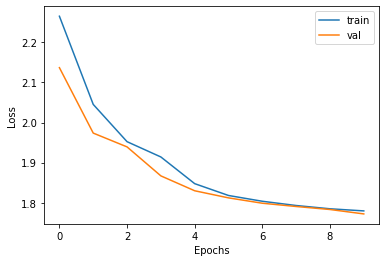

In [11]:
# Initialise the CNN
NN = NeuralNetwork(VanillaCNN)
NN.reset_model()
NN.initialise(loss_function = nn.CrossEntropyLoss(), optimizer = torch.optim.Adam(VanillaCNN.parameters(),lr= 0.001) )
# Fit and validate the CNN
NN.fit(train_loader, test_loader, max_epochs = 10)
# Evaluate the CNN
y_pred, y_test = NN.evaluate(test_loader,plot_flag = True)

#### Learning rate

One thing to note is the variability of accuracy across different tests. This behaviour is due to training with mini batches. In fact, repeatedly taking different subsets for gradient evaluation also results in different 'directions' for gradient descent. In this case, an attempt was made to contain this characteristic by using a lower learning rate.

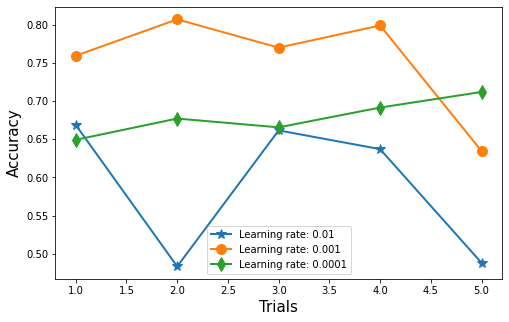

In [14]:
# Initilise the architecture
NN = NeuralNetwork(VanillaCNN)

# Looping variables
learning_rates = [0.01, 0.001, 0.0001]
trials = 5

acc_plot = np.zeros((len(learning_rates),trials))

# Loop for the learning rates
for lr_index in range(len(learning_rates)):

    # Loop for the trials
    for ind in range(trials):
        NN.reset_model()
        NN.initialise(loss_function = nn.CrossEntropyLoss(), optimizer = torch.optim.Adam(VanillaCNN.parameters(),lr= learning_rates[lr_index]) )
        NN.fit(train_loader, test_loader, max_epochs = 15)
        y_pred, y_test = NN.evaluate(test_loader, plot_flag=False)
        acc_plot[ lr_index, ind] = accuracy_score(y_pred, y_test)

# Plot the accuracy vs trails for the different learning rates
fig, ax = plt.subplots(figsize= (8,5))
ax.plot(range(1,6),acc_plot[0,:],linewidth = 2, marker ="*", markersize = 10, label= "Learning rate: 0.01")
ax.plot(range(1,6),acc_plot[1,:],linewidth = 2, marker ="o", markersize = 10, label= "Learning rate: 0.001")
ax.plot(range(1,6),acc_plot[2,:],linewidth = 2, marker ="d", markersize = 10, label= "Learning rate: 0.0001")
ax.set_xlabel("Trials",fontsize= 15)
ax.set_ylabel("Accuracy",fontsize= 15)
#ax.set_ylim(0.5,1)
ax.legend();
#plt.savefig("../acc_trials")    

### Improved CNN

**Improved CNN**:

- 1st Convolution: 32@3x3 filter, stride 1, padding = 1
- Activation function: ReLu
- Dropout 2D: 0.5
----------------------
- 2nd Convolution: 64@5x5 filter, stride 1, padding = 2
- Activation function: ReLu
- 2d normalization
- Dropout 2D: 0.5
- Max Pooling: 2x2 filter, stride 2
----------------------
- 3rd Convolution: 128@3x3 filter, stride 1, padding = 1
- Activation function: ReLu
- Dropout 2D: 0.5
----------------------
- 4th Convolution: 64@5x5 filter, stride 1, padding = 2
- Activation function: ReLu
- 2d normalization
- Dropout 2D: 0.5
- Max Pooling: 2x2 filter, stride 2
----------------------
- Flatten the output for fully connected layer
- 3 dense layers (3136 input nodes, 256  hidden nodes, 128  hidden nodes, 10 output nodes) 


In [ ]:
# An improved version of a convolutional neural network
ImprovedCNN = ImprovedCNN().to(device)

Accuracy: 0.86


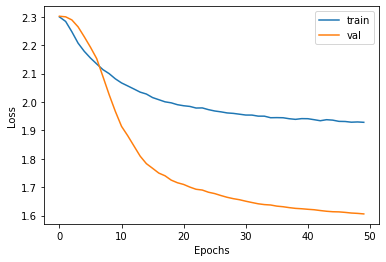

In [ ]:
# Initialise the CNN
NN = NeuralNetwork(ImprovedCNN)
NN.reset_model()
NN.initialise(loss_function = nn.CrossEntropyLoss(), optimizer = torch.optim.Adam(ImprovedCNN.parameters(),lr= 0.0001) )
# Fit and validate the CNN
NN.fit(train_loader, test_loader, max_epochs = 50)
# Evaluate the CNN
y_pred, y_test = NN.evaluate(test_loader,plot_flag = False)

Plot of the loss for training and validation:

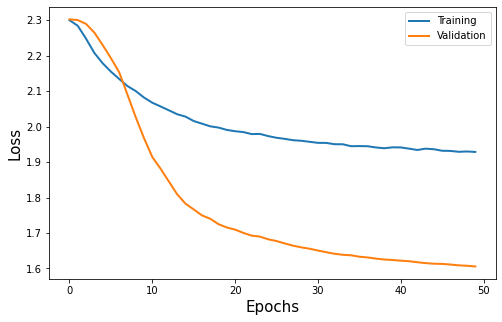

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(NN.L_history,linewidth=2,label="Training")
ax.plot(NN.L_history_val,linewidth=2,label="Validation")
ax.set_xlabel("Epochs",fontsize= 15)
ax.set_ylabel("Loss",fontsize= 15)
ax.legend();
#plt.savefig("../loss_final")

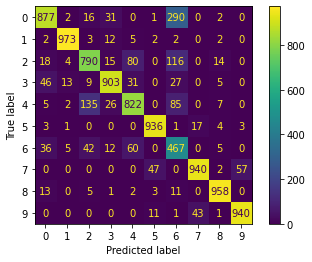

In [ ]:
# Draw the confusion matrix
cm = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2","3","4","5","6","7","8","9"])
disp.plot()
#plt.savefig("../cm_final")